## In this notebook, we will walk you through the steps to find the optimal policy using value iteration algorithm

In [1]:
# Importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rn
from cvxopt import solvers, matrix
import seaborn as sns

## Defining and visualizing the reward function

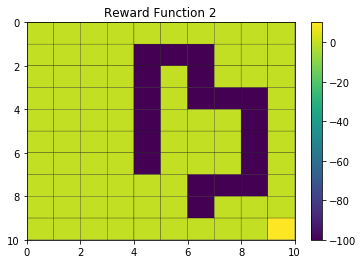

In [2]:
# Reward function 2
reward_fnx2 = np.array([[0,0,0,0,0,0,0,0,0,0], 
         [0,0,0,0,-100,-100,-100,0,0,0], 
         [0,0,0,0,-100,0,-100,0,0,0], 
         [0,0,0,0,-100,0,-100,-100,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,-100,0,0,0,-100,0],
         [0,0,0,0,0,0,-100,-100,-100,0],
         [0,0,0,0,0,0,-100,0,0,0],
         [0,0,0,0,0,0,0,0,0,10]])

# Visualizing the reward
plt.pcolor(reward_fnx2,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Reward Function 2")
plt.show()

## Setting up the environment of the MDP

In [3]:
# Initialize the state space
k=0
state_space = np.zeros((10,10))
for i in range(0,10):
    for j in range(0,10):
        state_space[j][i]=k
        k+=1
        
# probabiliy transition matrix for moving from one state to another
def state_transition_probabilities(w):
    P_up= np.zeros((100,100)) #Up
    P_down= np.zeros((100,100)) #Down
    P_left= np.zeros((100,100)) #Left
    P_right= np.zeros((100,100)) #Right
 
    for i in range(0,100):
        if(i%10==0):
            P_up[i][i]+=w/4
        else:
            P_up[i][i-1]=1-w+w/4
        if(i-10<0):
            P_up[i][i]+=w/4
        else:
            P_up[i][i-10]=w/4
        if(i+10>99):
            P_up[i][i]+=w/4
        else:
            P_up[i][i+10]=w/4
        if((i+1)%10==0):
            P_up[i][i]+=w/4
        else:
            P_up[i][i+1]=w/4
        if(i%10==0):                     
            P_up[i][i]+=1-w   
        
    for i in range(0,100):
        if(i%10==0):
            P_down[i][i]+=w/4
        else:
            P_down[i][i-1]=w/4
        if(i-10<0):
            P_down[i][i]+=w/4
        else:
            P_down[i][i-10]=w/4
        if(i+10>99):
            P_down[i][i]+=w/4
        else:
            P_down[i][i+10]=w/4
        if((i+1)%10==0):
            P_down[i][i]+=w/4
        else:
            P_down[i][i+1]=1-w+w/4
        if((i+1)%10==0):                      
            P_down[i][i]+=1-w
    
    for i in range(0,100):
        if(i%10==0):
            P_left[i][i]+=w/4
        else:
            P_left[i][i-1]=w/4
        if(i-10<0):
            P_left[i][i]+=w/4
        else:
            P_left[i][i-10]=1-w+w/4
        if(i+10>99):
            P_left[i][i]+=w/4
        else:
            P_left[i][i+10]=w/4
        if((i+1)%10==0):
            P_left[i][i]+=w/4
        else:
            P_left[i][i+1]=w/4
        if(i-10<0):                      
            P_left[i][i]+=1-w

    for i in range(0,100):
        if(i%10==0):
            P_right[i][i]+=w/4
        else:
            P_right[i][i-1]=w/4
        if(i-10<0):
            P_right[i][i]+=w/4
        else:
            P_right[i][i-10]=w/4
        if(i+10>99):
            P_right[i][i]+=w/4
        else:
            P_right[i][i+10]=1-w+w/4
        if((i+1)%10==0):
            P_right[i][i]+=w/4
        else:
            P_right[i][i+1]=w/4
        if(i+10>99):                      
            P_right[i][i]+=1-w

    return P_up, P_down, P_left, P_right




## Value iteration algorithm

In [4]:

def value_iteration(state_space,reward_fnx,P_up, P_down, P_left, P_right,w,gamma,epsilon):
    current_state=np.zeros(100)
    delta=np.inf
    r = (reward_fnx.T).ravel()
    steps = 0
    while(delta>epsilon):
        delta=0
        prev=np.copy(current_state)
        for s in range(0,100):
            up=np.sum(P_up[s]*(r+gamma*prev))
            down=np.sum(P_down[s]*(r+gamma*prev))
            left=np.sum(P_left[s]*(r+gamma*prev))
            right=np.sum(P_right[s]*(r+gamma*prev))
            current_state[s]=max(up,down,right,left)
            delta=max(delta,abs(prev[s]-current_state[s]))
        steps+=1
    copy_of_state = current_state.copy()
    current_state = np.transpose(current_state.reshape(10,10))
    return current_state, steps,up,down,left,right,copy_of_state


def value_iteration_with_intervals(state_space,reward_fnx,P_up, P_down, P_left, P_right,w,gamma,epsilon,optimal_steps=32):
    current_state=np.zeros(100)
    snapshot = []
    delta=np.inf
    r = (reward_fnx.T).ravel()
    intervals = np.round(np.linspace(1,optimal_steps-1,5))
    steps = 0
    while(delta>epsilon):
        if steps in intervals:
            current_state_ = np.copy(current_state)
            current_state_ = np.transpose(current_state_.reshape(10,10))
            snapshot.append(current_state_) 
        delta=0
        prev=np.copy(current_state)
        for s in range(0,100):
            up=np.sum(P_up[s]*(r+gamma*prev))
            down=np.sum(P_down[s]*(r+gamma*prev))
            left=np.sum(P_left[s]*(r+gamma*prev))
            right=np.sum(P_right[s]*(r+gamma*prev))
            current_state[s]=max(up,down,right,left)
            delta=max(delta,abs(prev[s]-current_state[s]))
        steps+=1
    return snapshot



## Computing the optimal state-value using the value iteration algorithm

In [5]:
# Parameters
w = 0.1
gamma = 0.8
epsilon = 0.01

# Convergence
P_up, P_down, P_left, P_right = state_transition_probabilities(w)
state, steps, _, _, _, _, _ = value_iteration(state_space,reward_fnx2,P_up,P_down,P_left,P_right,w,gamma,epsilon)
print("Number of steps needed to converge:", steps)

Number of steps needed to converge: 32


Text(0.5,1,'Optimal state values for Reward function 2(After Iterations = 32)')

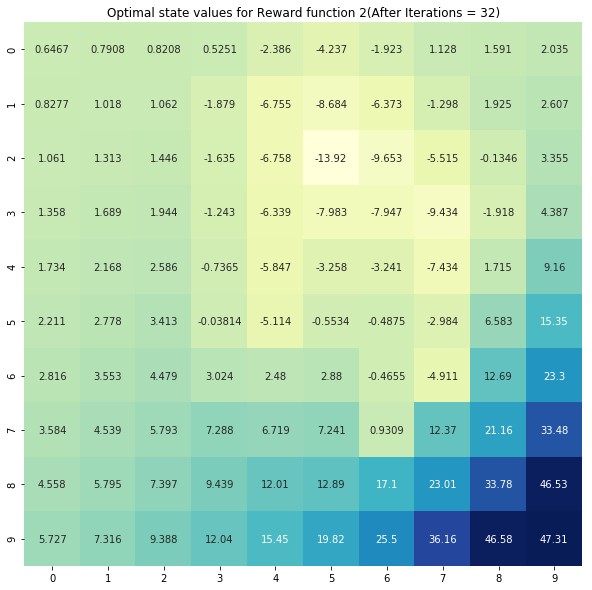

In [6]:
# Plotting optimal value

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(state, annot=True, fmt='.4g', cmap="YlGnBu", cbar=False)
plt.title("Optimal state values for Reward function 2(After Iterations = 32)")

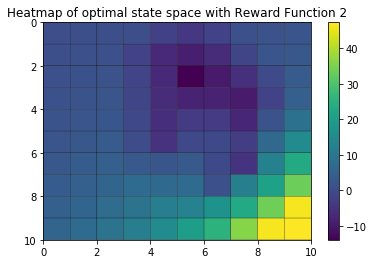

In [7]:
plt.pcolor(state,edgecolors='black')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heatmap of optimal state space with Reward Function 2")
plt.show()

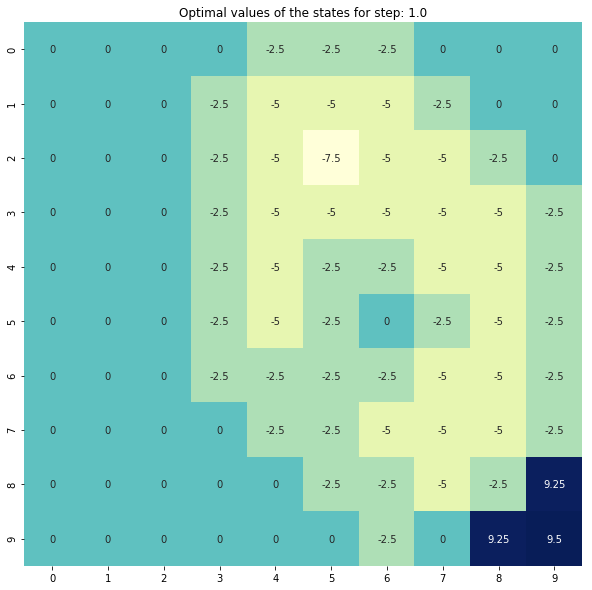

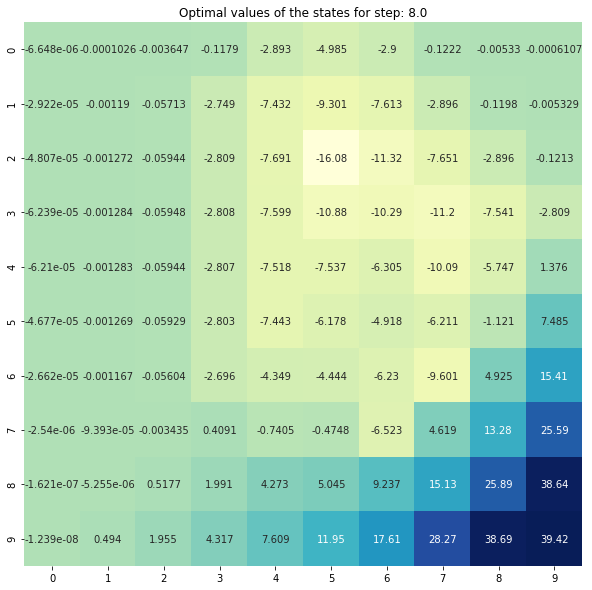

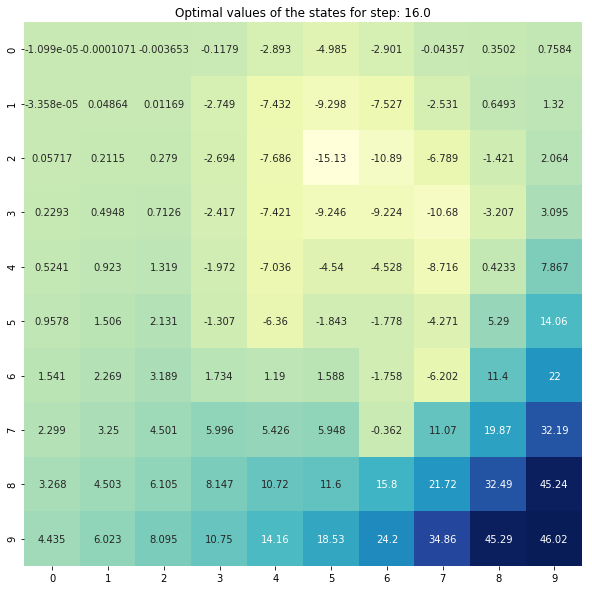

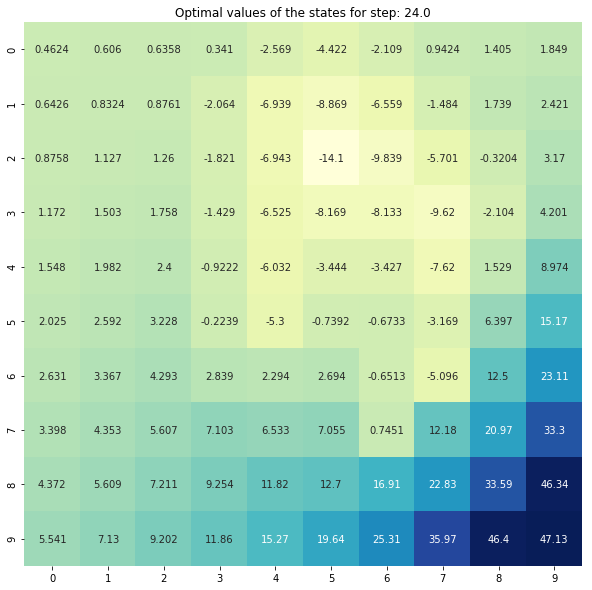

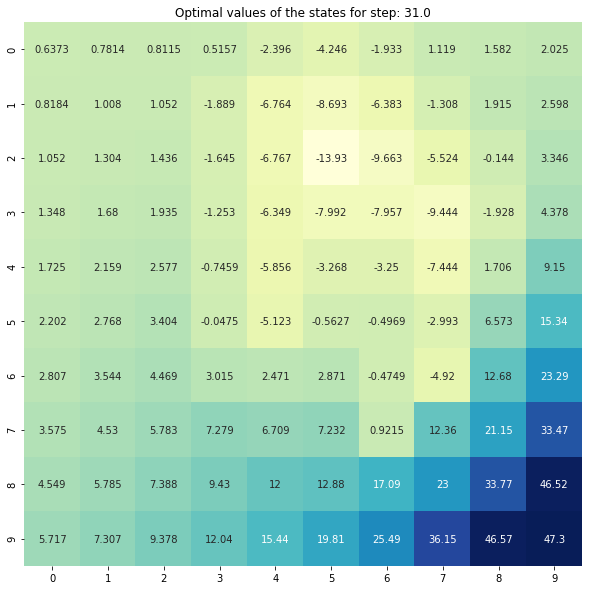

In [8]:
# Snapshots of the state-value until convergence
snapshots = value_iteration_with_intervals(state_space,reward_fnx2,P_up,P_down,P_left,P_right,w,gamma,epsilon,optimal_steps=32)

intervals = np.round(np.linspace(1, 31, 5))
for k in range(len(snapshots)):
    N = intervals[k]
    state = snapshots[k]
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(state, annot=True, fmt='.4g', cmap="YlGnBu", cbar=False)
    plt.title("Optimal values of the states for step: "+str(N))
    plt.show()

## Finding the optimal policy using the state-value function

In [11]:
## Function for plotting the optimal actions at each state in the grid
## The function takes as input the matrix containing optimal actions
## and plots the actions for each state on the grid

def plot_arrow(action_matrix):
    
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[j][i]
            arrow = ''
            if(c == 0):
                arrow = u'↑'
            elif(c == 1):
                arrow = u'↓'
            elif(c == 2):
                arrow = u'←'
            else:
                arrow = u'→'
            
            ax.text(i + 0.5, j + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()


def find_policy(state_space,reward_fnx,P_up,P_down,P_left,P_right,w,gamma,epsilon):
    policy=np.zeros(100)
    arrows=np.zeros(100) 
    r = (reward_fnx.T).ravel()
    _,_,up,down,left,right,current_state = value_iteration(state_space,reward_fnx,P_up,P_down,P_left,P_right,w,gamma,epsilon)
    for s in range(0,100):
        up=np.sum(P_up[s]*(r+gamma*current_state))
        down=np.sum(P_down[s]*(r+gamma*current_state))
        left=np.sum(P_left[s]*(r+gamma*current_state))
        right=np.sum(P_right[s]*(r+gamma*current_state))
        arr=[up,down,left,right]
        policy[s]=np.amax(arr)
        arrows[s]=arr.index(np.amax(arr))
    arrows = np.transpose(arrows.reshape(10,10))
    policy = np.transpose(policy.reshape(10,10))
    plot_arrow(arrows)
    return policy

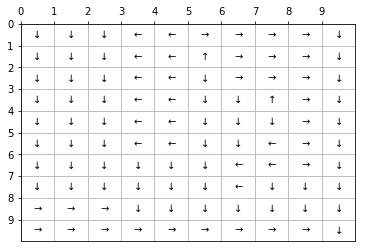

In [12]:
policy = find_policy(state_space,reward_fnx2,P_up,P_down,P_left,P_right,w,gamma,epsilon)